In [33]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime

from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

%aimport features.bathy_smoothing
from features.resample_roms import resample
from features.bathy_smoothing import smoothing_PlusMinus_rx0,smoothing_PositiveVolume_rx0
from features.cartesian_grid_2d import haversine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
#run = os.environ.get('run')
run ='waom10'
mr = 10 #km

In [35]:
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(-3000,3300+mr/2,mr/2),np.arange(-2700,2600+mr/2,mr/2))
#x,y = np.meshgrid(np.arange(-4300,4300+mr/2,mr/2),np.arange(-3700,3600+mr/2,mr/2))

x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

In [36]:
def inverse_polar_stereo(x=None, y=None, xcentre=None, ycentre=None, ref_lat=None):


    #slat = -71.0
    slat = ref_lat
    slon = 0.0
    re = 6378.137
    e2 = 6.694379852e-3
    pi = 3.141592654
    e = np.sqrt(e2)

    cdr = pi / 180.0
    mflag = -1


    if (abs(slat) == 90):
        then
        
        rho = 2. * re  / np.sqrt((1 + e)  ** (1 + e)  * (1 - e)  ** (1 - e))
        
    else:
        sl = abs(slat)  * cdr
        tc = np.tan(pi / 4 - sl / 2)  / ((1 - e  * np.sin(sl))  / (1 + e  * np.sin(sl)))  ** (e  / 2)
        mc = np.cos(sl)  / np.sqrt(1 - e2  * (np.sin(sl)  ** 2))
        rho = re  * mc  / tc


    a1 = 5. / 24. * e2  ** 2
    a2 = 1. / 12. * e2  ** 3
    a3 = 7. / 48. * e2  ** 2
    a4 = 29. / 240. * e2  ** 3
    a5 = 7. / 120. * e2  ** 3


    t = np.sqrt((x - xcentre)  ** 2 + (y - ycentre)  ** 2)  / rho
    chi = (pi  / 2) - 2. * np.arctan(t)
    alat = chi + ((e2  / 2) + a1 + a2)  * np.sin(2. * chi) + (a3 + a4)  * np.sin(4. * chi) + a5  * np.sin(6. * chi)
    alat = -alat  / cdr
    alon = -np.arctan2(-(x - xcentre), (y - ycentre))  / cdr + slon
    
    return alat,alon

In [37]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back
#from mpl_toolkits.basemap import Basemap
#m = Basemap(projection='spstere',lon_0=0,boundinglat=-50,lat_ts=-71.0,ellps='WGS84')

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
#lonBM,latBM=m(x*1000+m.urcrnrx/2,y*1000+m.urcrnry/2,inverse=True)
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)
#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])

#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]
#lon_rhoBM = lonBM[1::2,1::2]
#lat_rhoBM = latBM[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [38]:
bedmap_path = os.path.join(os.environ.get('extdir'),'bedmap2','bedmap2.mat')
import h5py
bedmap = {}
f = h5py.File(bedmap_path)
for k, v in f.items():
    bedmap[k] = np.flipud(np.rot90(np.array(v)))

In [39]:
bedmap['elev_bed']*=-1
bedmap['zice'] = -(bedmap['thick']-bedmap['elev_surf'])
bedmap['zice'][np.isnan(bedmap['zice'])]=0
bedmap['mask']=np.zeros_like(bedmap['thick'])
bedmap['mask'][np.isnan(bedmap['thick'])] = 1
bedmap['mask'][np.nonzero(bedmap['mask_rock'])] = 0

In [40]:
xvbl = np.nonzero(bedmap['x'][0,:]==bedmap['x_mask_vostok'][0,0])[0][0]
yvbl = np.nonzero(bedmap['y'][:,0]==bedmap['y_mask_vostok'][0,0])[0][0]

xvbu = xvbl + np.size(bedmap['mask_vostok'],1)
yvbu = yvbl + np.size(bedmap['mask_vostok'],0)

bedmap['mask_ice'][yvbl:yvbu,xvbl:xvbu]=bedmap['mask_vostok']
bedmap['mask'][bedmap['mask_ice']==1]=1

In [41]:
xbl = np.nonzero((x_rho[0,0] == bedmap['x'][0,:]))[0][0]
ybl = np.nonzero((y_rho[0,0] == bedmap['y'][:,0]))[0][0]
xbu = xbl + ((np.size(x_rho,1))*mr)
ybu = ybl + ((np.size(x_rho,0))*mr)

roms_tmp = {}
for var in ['mask','mask_ice','elev_bed','zice']:
    roms_tmp[var] = bedmap[var][ybl:ybu:mr,xbl:xbu:mr]

mask


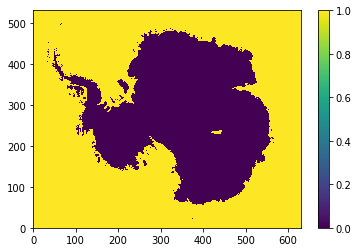

mask_ice


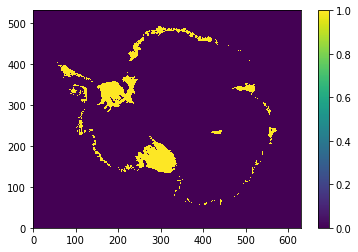

elev_bed


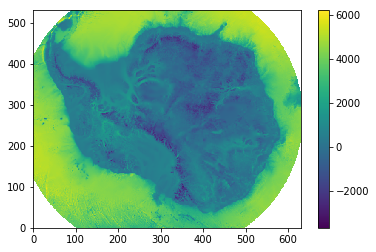

zice


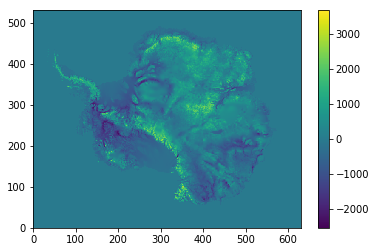

In [42]:
%matplotlib inline
plt.close()
for k,v in roms_tmp.items():
    print(k)
    plt.pcolormesh(v)
    plt.colorbar()
    plt.show()

In [43]:
from pyresample import kd_tree, utils, geometry

#load rtopo bed and ice topography and resample to rho points
rtopo_path = os.path.join(os.environ.get('extdir'),'rtopo','RTopo-2.0.1_30sec_*_S30.nc')
rtopo = xr.open_mfdataset(rtopo_path,data_vars='minimal')#.sel(latdim=np.arange(0,7501,50),londim=np.arange(0,43201,100))

rt_lon,rt_lat = np.meshgrid(rtopo.lon.values,rtopo.lat.values)
rt_lon,rt_lat = utils.check_and_wrap(rt_lon,rt_lat)

rt_def = geometry.SwathDefinition(lons=rt_lon,lats=rt_lat)
roms_def = geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
#roms_defBM = geometry.SwathDefinition(lons=lon_rhoBM,lats=lat_rhoBM)


wf = lambda r: 1/r

rt_on_roms = kd_tree.resample_custom(rt_def,rtopo.bedrock_topography.values,roms_def,\
                                     radius_of_influence=5000,neighbours=2,weight_funcs=wf,nprocs=16)


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 2 neighbours within 5000 m for some data points
  (neighbours, radius_of_influence))


In [44]:
idx_bad =  np.isnan(roms_tmp['elev_bed'])

roms_tmp['elev_bed'][idx_bad]=-rt_on_roms[idx_bad]

sr = round((mr/110*3)*10)/10
print(sr)
idx_sr = np.nonzero((lat_rho>-60.05)&(lat_rho<-60.05+sr))
roms_tmp['elev_bed'][idx_sr]=np.nan

from scipy.interpolate import LinearNDInterpolator

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = LinearNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

roms_tmp['elev_bed']=NDinterp(roms_tmp['elev_bed'])
bed_raw = roms_tmp['elev_bed']

0.3


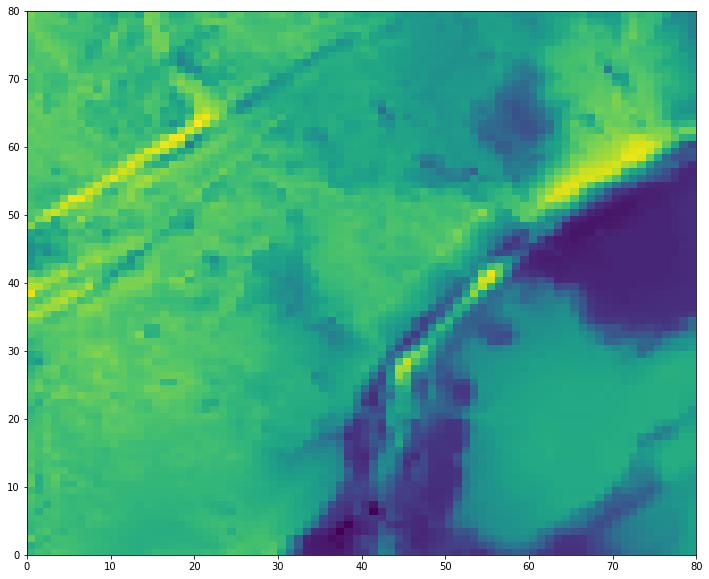

In [45]:
plt.close()
plt.figure(figsize=(12,10))
plt.pcolormesh(roms_tmp['elev_bed'][-80:,0:80])
plt.show()

In [46]:
idx_north_land = (roms_tmp['elev_bed']<0) & (lat_rho>-60)
roms_tmp['mask'][idx_north_land]=0
roms_tmp['zice'][lat_rho>-60]=0.0
roms_tmp['wct'] = roms_tmp['elev_bed'] + roms_tmp['zice']

mask


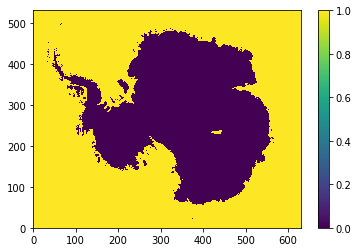

mask_ice


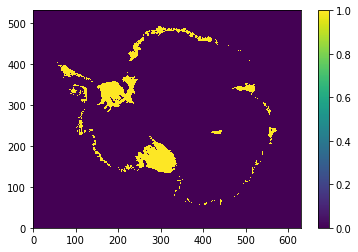

elev_bed


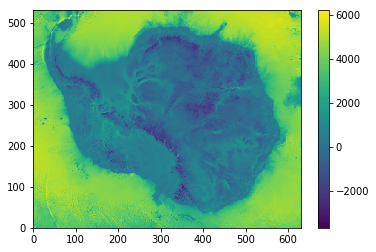

zice


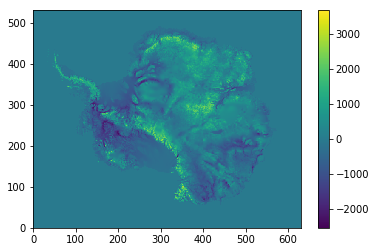

wct


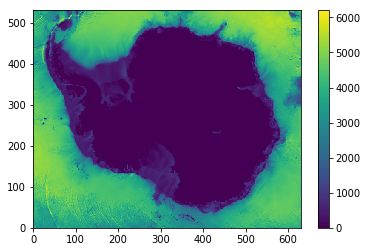

In [47]:
%matplotlib inline
plt.close()
for k,v in roms_tmp.items():
    print(k)
    plt.pcolormesh(v)
    plt.colorbar()
    plt.show()

In [48]:
from features.log_progress import log_progress
from features.mask_roms_uvp import uvp_masks
import numpy as np
import bathy_smoother

def smoothing_PlusMinus_rx0(MSK, Hobs, rx0max, AreaMatrix,rounds):
    """
    This program use the Mellor-Ezer-Oey method (Mellor et al., 1994).
    The bathymetry is optimized for a given rx0 factor by doing a sequence
    of increase/decrease at adjacent cells.

    Usage:
    RetBathy, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(MSK, Hobs, rx0max, AreaMatrix)

    ---MSK(eta_rho,xi_rho) is the mask of the grid
         1 for sea
         0 for land
    ---Hobs(eta_rho,xi_rho) is the raw depth of the grid
    ---rx0max is the target rx0 roughness factor
    ---AreaMatrix(eta_rho,xi_rho) is the matrix of areas at
       rho-points.
    """

    RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(Hobs,MSK)
    print('Old Max Roughness value is: ', RoughMat.max())
    
    eta_rho, xi_rho = Hobs.shape

    ListNeigh = np.array([[1, 0],
                          [0, 1],
                          [-1, 0],
                          [0, -1]])

    RetBathy = Hobs.copy()

    HmodifVal = 0
    TheMultiplier = (1 - rx0max) / (1 + rx0max)
    tol = 0.000001
    ValueFct = 0

    for round in log_progress(range(rounds),name='steps'):
        IsFinished = 1
        for iEta in range(eta_rho):
            for iXi in range(xi_rho):
                if (MSK[iEta, iXi] == 1):
                    Area = AreaMatrix[iEta, iXi]
                    for ineigh in range(4):
                        iEtaN = iEta + ListNeigh[ineigh,0]
                        iXiN = iXi + ListNeigh[ineigh,1]
                        if (iEtaN <= eta_rho-1 and iEtaN >= 0 and iXiN <= xi_rho-1 \
                            and iXiN >= 0 and MSK[iEtaN,iXiN] == 1):
                            AreaN = AreaMatrix[iEtaN,iXiN]
                            LowerBound = RetBathy[iEtaN,iXiN] * TheMultiplier
                            if ((RetBathy[iEta,iXi] - LowerBound) < -tol):
                                IsFinished = 0
                                h = (TheMultiplier * RetBathy[iEtaN,iXiN] - RetBathy[iEta,iXi]) \
                                         / (AreaN + TheMultiplier * Area)
                                RetBathy[iEta,iXi] = RetBathy[iEta,iXi] + AreaN * h
                                RetBathy[iEtaN,iXiN] = RetBathy[iEtaN,iXiN] - Area * h
                                HmodifVal = HmodifVal + abs(h)
                                ValueFct = ValueFct + abs(h) * (Area + AreaN)
        
        if (IsFinished == 1):
            break
            
    H = AreaMatrix * Hobs * MSK
    TheBathymetry1 = H.sum()
    H = AreaMatrix * RetBathy * MSK
    TheBathymetry2 = H.sum()
    DeltaBathymetry = TheBathymetry1 - TheBathymetry2
    print('DeltaBathymetry = ', DeltaBathymetry)

    RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(RetBathy,MSK)
    print('New Max Roughness value is: ', RoughMat.max())
    
    return RetBathy, HmodifVal, ValueFct

In [53]:
# crop mountains down
min_depth0 = 0.1

bed = roms_tmp['elev_bed']
ice = roms_tmp['zice']

ice[bed < min_depth0] = 0
bed[bed < min_depth0] = min_depth0

wct = bed + ice
bed[wct==0] = -ice[wct==0] + min_depth0
wct = bed + ice

rx0in = 0.3
max_iter = 150

Area = 1/(pm*pn)

wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)

bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)

ice = wct - bed

Old Max Roughness value is:  0.999873904546


VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

DeltaBathymetry =  -8.0
New Max Roughness value is:  0.300004449769
Old Max Roughness value is:  0.999907757587


VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

DeltaBathymetry =  24.0
New Max Roughness value is:  0.300004506855


In [55]:
# crop mountain again and ensure thin layer between ice and bed
mask = roms_tmp['mask']
ice[ice > 0] = 0
bed[mask==0] = -ice[mask==0] + min_depth0
wct = bed + ice
ii = (wct < min_depth0) & (mask == 1)
bed[ii] = -ice[ii] + min_depth0
wct = bed + ice

In [56]:
# deepen bed under ice to min depth
ii = (bed + ice < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

In [57]:
# smooth bathy again, since you just introduced steps and ensure min depth after
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
bed[mask==0] = -ice[mask==0] + min_depth0
ii = (bed + ice < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

Old Max Roughness value is:  0.99981227533


VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

DeltaBathymetry =  8.0
New Max Roughness value is:  0.300004506855


mask


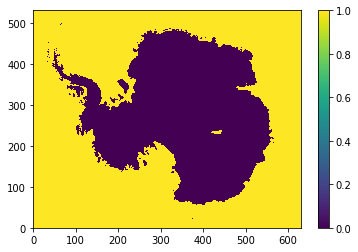

mask_ice


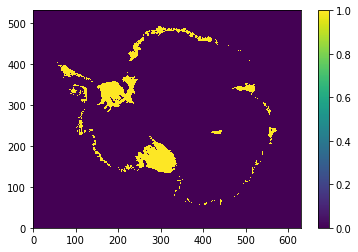

elev_bed


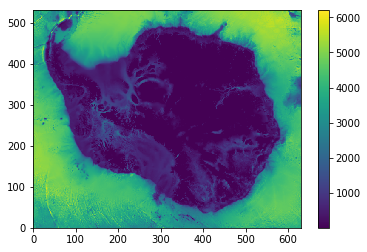

zice


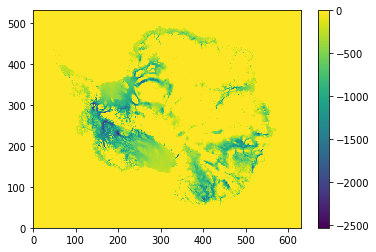

wct


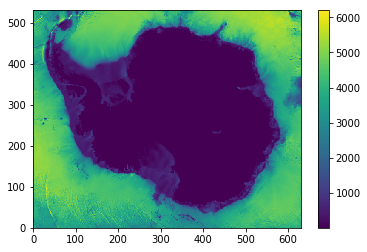

In [18]:
plt.close()
for k,v in roms_tmp.items():
    print(k)
    plt.pcolormesh(v)
    plt.colorbar()
    plt.show()

In [60]:
mindxy = mr*1000
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))

max fast DT in s following CFL:  40.5480199557


In [61]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
hraw_da = xr.DataArray(bed_raw,name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})

from features.mask_roms_uvp import uvp_masks

mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
                'hraw':hraw_da,
                'zice':zice_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

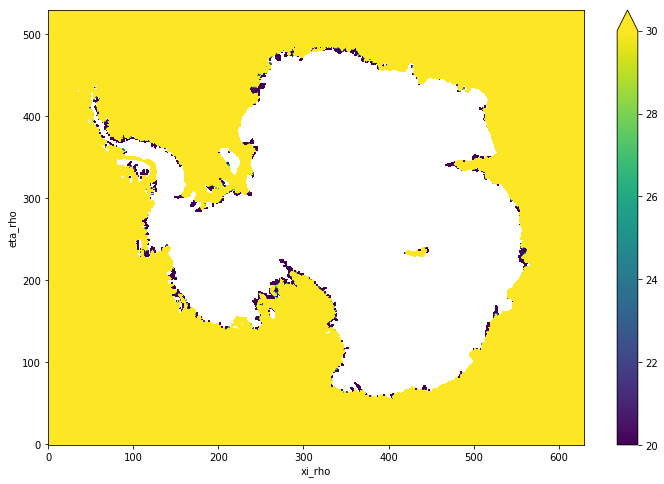

In [90]:
%matplotlib inline
plt.close()
plt.figure(figsize=(12,8))
(grd.h+grd.zice).where(grd.mask_rho).plot(vmax=30)
plt.show()

In [91]:
out_path = os.path.join(os.environ.get('prodir'),'waom'+str(mr)+'_test_grd.nc')
#out_path = '~/raijin/short/m68/oxr581/waom10_test/waom10_grd_smooth.nc'
grd.to_netcdf(out_path,unlimited_dims='bath')

Below just left overs from development

In [92]:
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_stable_grd.nc')
grd_old = xr.open_dataset(grd_path)

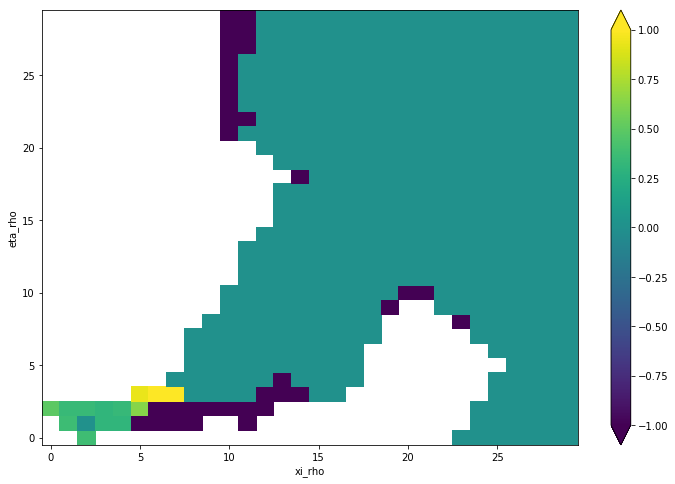

In [96]:
plt.close()
plt.figure(figsize=(12,8))
(grd.h-grd_old.h).where(grd_old.mask_rho)[300:330,150:180].plot(vmin=-1,vmax=1)
plt.show()